In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [2]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [4]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [6]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [7]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [8]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [9]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 1000

main_seed = seed_number

print(seed_number)

1000


#Params

In [10]:
params_dict = ri.params_dict

In [11]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [17]:
params_dict['LightGBM_2'].update({'random_state': seed_number})
#--------------Create dataset with Approved and Rejected---------------
X_train_ls, y_train_ls, X_unl_ls = X_train_acp.copy(), y_train_acp.copy(), X_train_rej.copy()

X_combined = pd.concat([X_train_ls, X_unl_ls])

y_unl_ls = np.array([-1]*X_unl_ls.shape[0])
y_combined = np.concatenate([y_train_ls.array, y_unl_ls])
y_combined = pd.Series(y_combined, index=X_combined.index)

n_labeled_points = y_train_ls.shape[0]
indices = np.arange(y_combined.shape[0])

#--------------Predict labels on the unlabeled data---------------
lp_model = tr.create_pipeline(X_combined, y_combined, LabelSpreading(**params_dict['LabelSpreading_2']))
lp_model.fit(X_combined, y_combined)
predicted_labels = lp_model['classifier'].transduction_[indices[n_labeled_points:]]

y_label_pred_s = pd.Series(predicted_labels, index=X_unl_ls.index)

new_X_train = pd.concat([X_train_ls, X_unl_ls])
new_y_train = pd.concat([y_train_ls, y_label_pred_s])

clf_LS = tr.create_pipeline(new_X_train, new_y_train, LGBMClassifier(**params_dict['LightGBM_2']))
clf_LS.fit(new_X_train, new_y_train,)

#--------------Fit classifier---------------
#Create a new classifier pipeline using labeled and unlabeled data, and fit it


Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['SK_ID_CURR', 'TARGET',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLAG_MOBIL',
                                                   'FLAG_EMP_PHONE'...
                                                   'EMERGENCYSTATE_MODE'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=1000,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [143]:
from scipy import stats
# lp_model['classifier'].transduction_[indices[n_labeled_points:]]
pred_entropies = stats.distributions.entropy(lp_model['classifier'].label_distributions_.T)


In [ ]:
np.sort(pred_entropies[y_combined == 1])

In [153]:
np.sort(pred_entropies[y_combined == 0])

array([0.        , 0.        , 0.        , ..., 0.47964688, 0.50489934,
       0.51239301])

In [160]:
lp_model['classifier'].transduction_[y_combined == -1].shape

(119443,)

In [152]:
np.sort(lp_model['classifier'].label_distributions_[y_combined,1][y_combined == 0])

(36169,)

In [120]:
lp_model['classifier'].label_distributions_[indices[:n_labeled_points],1][y_train_ls == 0].sum()

143.93023478374255

In [123]:
y_train_ls[y_train_ls == 1].shape

(1833,)

In [164]:
lp_model['classifier'].label_distributions_[y_combined == -1][:,1]

array([0.10675477, 0.0030983 , 0.02824937, ..., 0.00221102, 0.00078112,
       0.00172837])

In [69]:
dex.get_shapes(new_X_train, X_train_ls, X_unl_ls, X_combined, predicted_labels)

new_X_train : (157445, 15)
X_train_ls : (38002, 15)
X_unl_ls : (119443, 15)
X_combined : (157445, 15)
predicted_labels : (119443,)


In [132]:
lp_model['classifier'].label_distributions_[:,1][y_combined == 0].sum()

143.93023478374255

In [37]:
uncertainty_index = np.argsort(pred_entropies)[-10:]

In [38]:
pred_entropies[uncertainty_index]

array([0.69314706, 0.69314707, 0.69314711, 0.69314714, 0.69314714,
       0.69314716, 0.69314717, 0.69314717, 0.69314718, 0.69314718])

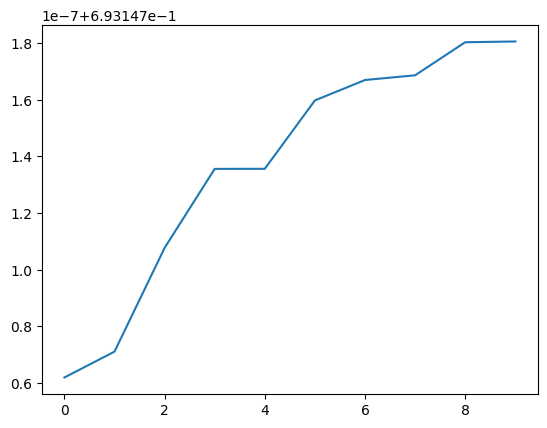

In [41]:
plt.plot(pred_entropies[uncertainty_index])

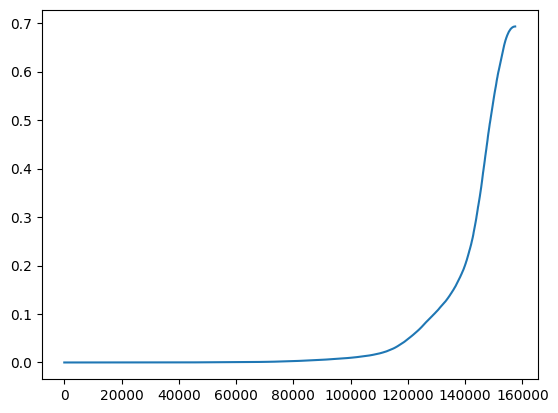

In [24]:
plt.plot(sorted(pred_entropies))

In [13]:
N_splits=5
kf = KFold(n_splits=N_splits)   #80-20 split for train-test
hist_dict = {}
data_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)
    
    data_dict[fold_number] = [X_train_acp, X_train_rej, y_train_acp, y_train_rej,
                               X_test_acp, X_test_rej, y_test_acp,
                               X_val_acp, X_val_rej, y_val_acp]
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    models_dict = {}

    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    
    models_dict['BM'] = benchmark

    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    models_dict.update(
        ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                                 X_val_acp, y_val_acp, iterations=100,p = 0.07, output=-1,
                                 seed=seed_number, technique= 'LS'))
    
    hist_dict[fold_number] = models_dict
    # metrics_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    print(fold_number)
    # break

KeyboardInterrupt: 

In [ ]:
# main_seed = 7777
seed_number = main_seed

In [ ]:
for fold_number in range(N_splits):
    print(seed_number+fold_number)

7777
7778
7779
7780
7781


In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    seed_number = seed_number+fold_number
    filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
    datasets = joblib.load(filepath)


    values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
                            acp_rate=0.05).loc[
                                ["Overall AUC", "Kickout"]].T.to_numpy()
    weights = [10,1]
    criterias = np.array([True, True])
    t = top.Topsis(values, weights, criterias)
    t.calc()
    output = t.rank_to_best_similarity()[0] - 1
    print(f'best iteration: {output}')

    hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
    # break

best iteration: 18


In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)
    # break
mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

    

KeyError: 1

In [ ]:
metrics_dict[0]

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.729578,0.719508,0.727736,0.729200,0.707533,0.732998,0.730035,0.717336,0.715241
KS,0.338677,0.326551,0.346592,0.339654,0.317456,0.345958,0.333673,0.322026,0.319460
Balanced Accuracy,0.664787,0.662688,0.663577,0.668605,0.641827,0.659472,0.659542,0.656765,0.647841
Accuracy,0.744570,0.719697,0.709104,0.643738,0.747586,0.725865,0.794784,0.674041,0.749195
Precision,0.107853,0.101687,0.099889,0.091217,0.101289,0.102017,0.121626,0.092417,0.103612
Recall,0.576294,0.599455,0.613079,0.696185,0.524523,0.585831,0.509537,0.637602,0.535422
F1,0.181701,0.173879,0.171789,0.161301,0.169791,0.173772,0.196377,0.161435,0.173625
Approval Rate,0.899973,0.890386,0.892733,0.891191,0.866452,0.900979,0.894543,0.898901,0.902990
Kickout,0.000000,1.367951,0.235145,0.866112,0.602628,0.580068,0.958923,1.475527,1.508268
KG,0.000000,473.000000,90.000000,143.000000,141.000000,68.000000,36.000000,282.000000,352.000000


In [ ]:
metric = mean_metrics.loc[['Overall AUC', 'Kickout', 'Approval Rate']]

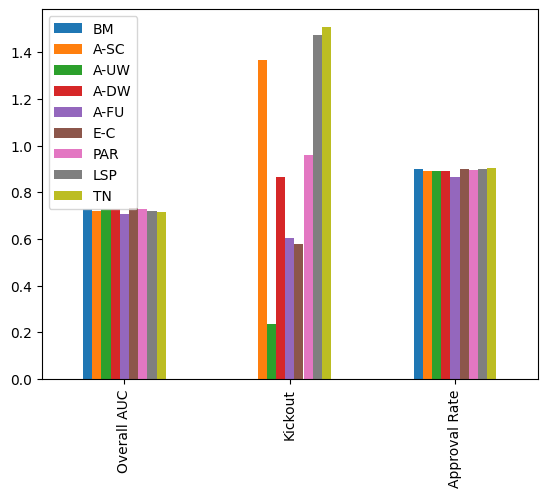

In [ ]:
metric.plot.bar()
plt.show()

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)

In [ ]:
cols = ['Overall AUC','Kickout',]

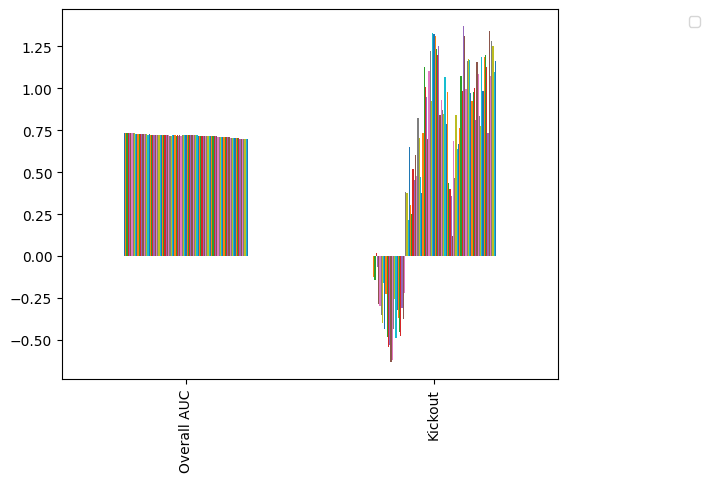

In [ ]:
metrics.loc[cols].plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

In [ ]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_91,TN_92,TN_93,TN_94,TN_95,TN_96,TN_97,TN_98,TN_99,TN_100
Overall AUC,0.732601,0.733048,0.733122,0.733048,0.732306,0.732120,0.729975,0.730628,0.730495,0.730218,...,0.705715,0.704575,0.703788,0.702120,0.701675,0.700258,0.700068,0.698581,0.698365,0.695927
KS,0.362753,0.360955,0.356273,0.357491,0.354289,0.353183,0.347506,0.356078,0.352652,0.354083,...,0.312758,0.305102,0.302152,0.301541,0.300287,0.299767,0.305850,0.301295,0.300491,0.295525
Balanced Accuracy,0.680909,0.676548,0.670136,0.669017,0.669549,0.672294,0.667299,0.670670,0.673198,0.674368,...,0.654546,0.651736,0.646211,0.649040,0.644336,0.648381,0.644410,0.647357,0.641858,0.641945
Accuracy,0.667227,0.690068,0.657910,0.684439,0.696668,0.688192,0.626335,0.626529,0.633840,0.643546,...,0.696732,0.656487,0.716985,0.677515,0.676027,0.663798,0.684892,0.681786,0.704950,0.697638
Precision,0.093220,0.095721,0.089485,0.092978,0.095073,0.094370,0.085141,0.085864,0.087211,0.088610,...,0.091247,0.085114,0.092332,0.087100,0.085753,0.085205,0.086939,0.087256,0.089175,0.088100
Recall,0.696011,0.661623,0.683631,0.651994,0.639615,0.654746,0.712517,0.719395,0.716644,0.708391,...,0.607978,0.646492,0.568088,0.617607,0.609354,0.631362,0.599725,0.609354,0.572215,0.580468
F1,0.164419,0.167246,0.158255,0.162747,0.165539,0.164963,0.152107,0.153417,0.155499,0.157516,...,0.158679,0.150424,0.158846,0.152669,0.150348,0.150147,0.151863,0.152653,0.154303,0.152982
Approval Rate,0.951796,0.952378,0.952443,0.951084,0.951731,0.953931,0.950566,0.952507,0.955354,0.955613,...,0.930896,0.934067,0.936914,0.935490,0.936978,0.938984,0.935167,0.937172,0.935296,0.937819
Kickout,0.000000,-0.000709,-0.004254,-0.009926,-0.008508,-0.012761,-0.012052,-0.014888,-0.016306,-0.012052,...,0.218692,0.234575,0.280098,0.257834,0.240533,0.250458,0.248332,0.267051,0.229613,0.229613
KG,0.000000,1.000000,6.000000,14.000000,12.000000,18.000000,17.000000,21.000000,23.000000,17.000000,...,204.000000,206.000000,215.000000,222.000000,222.000000,208.000000,211.000000,209.000000,213.000000,213.000000


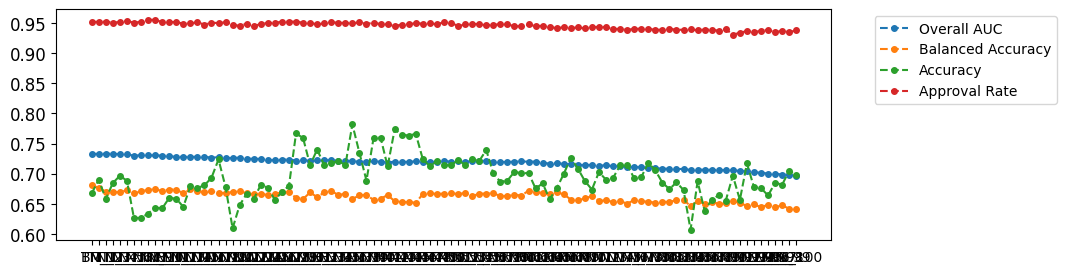

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

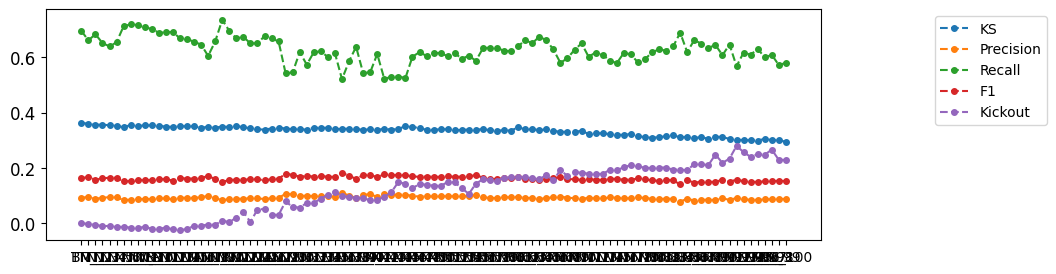

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()